# Path Planning

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S55_diffdrive_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from typing import List
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam

```{index} planning; path planning
```

> Samples are useful for planning as well.

<img src="Figures5/S55-Two-wheeled_Toy_Robot-05.jpg"  alt="Splash image with steampunk differential-drive robot" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

```{index} complete, path planning
```
Path planning is the problem of finding a collision-free path for
the robot from its starting configuration to a goal configuration.
This is one of the oldest fundamental problems in robotics.
Ideally, a path planning algorithm would guarantee to find a collision-free path whenever such a path
exists, and to terminate in finite time when no such path exists.
Such algorithms are said to be **complete**.
Unfortunately, it has been shown that the path planning problem is NP complete.
Numerous hardness results have been obtained for different versions of the problem,
but the sad fact is that planning collision-free paths is generally intractable
for even moderately complex robotic systems.
For this reason, modern path planning algorithms try to strike a balance between
completeness (often settling for weaker variations on this idea)
and efficiency,
while finding solution paths for most typical problems.

In this section, we will describe several approaches to path planning,
all of which operate in the configuration space, to illustrate
the range of trade-offs that exist in this domain.

## Configuration Space Obstacles

```{index} free configuration space, configuration space obstacle region
```
Although the robot moves physically in its workspace, the path planning problem is more easily addressed
if we work directly in the robot's configuration space.
As in Section 5.2, we will denote a robot configuration by $q$ and the configuration space of the robot by ${\cal Q}$.
In order to plan collision-free paths, it is useful to partition the configuration space into 
the set of collision-free configurations, ${\cal Q}_\mathrm{free}$ (often called the *free configuration space*)
and the set of configurations that result in a collision, ${\cal Q}_\mathrm{obst}$,
which is sometimes referred to as the *configuration space obstacle region*.

Let $R(q)$ denote the set of points in the workspace that are occupied by the robot when the robot is in configuration $q$,
and let ${\cal O}$ denote the obstacle region in the workspace.
We can define the set ${\cal Q}_\mathrm{obst}$ as
\begin{equation}
{\cal Q}_\mathrm{obst} = \{ q \in {\cal Q} \mid R(q) \cap {\cal O} = \emptyset \}
\end{equation}
The free configuration space is merely the complement of this set in $\cal Q$:
\begin{equation}
{\cal Q}_\mathrm{free} = {\cal Q} \backslash {\cal Q}_\mathrm{obst}
\end{equation}
We can now formally define a free path as a continuous map from the unit interval
(or any convenient interval that represents path length) as $\gamma : [0,1] \rightarrow {\cal Q}_\mathrm{free}$,
such that $q(0) = q_\mathrm{init}$ and $q(1) = q_\mathrm{goal}$.
In some cases we require that $\gamma$ also be differentiable, but this will not be necessary for our DDR.

When the dimension of the configuration space is small (e.g., ${\cal Q} \subset \mathbb{R}^2$),
it may be possible to explicitly compute ${\cal Q}_\mathrm{free}$;
however, the time required for this computation grows exponentially with the
dimension of the configuration space, so this approach is not taken for even moderately complex robotic systems.


## Value Iteration

```{index} value iteration, value function
```
In Chapter 4 we saw how the value function could be used to plan a path that led a robot with stochastic actions to a goal while avoiding obstacles.
We can apply this same method to the problem of planning collision-free paths in the configuration space.
We merely place a large negative reward along the configuration space obstacle boundaries, and a large positive reward at the goal configuration.
We can then use value iteration to compute an approximation to the value function over ${\cal Q}_\mathrm{free}$,
and merely follow the gradient
of the value function from the robot's initial configuration until it reaches the goal.
In cases where the robot's actions are not stochastic, we merely replace the probabilistic action model by a conditional probability
function that assigns probability one to the action's defined outcome
(i.e., there is no uncertainty in the result of applying the action).

There are several disadvantages to this approach.
First, to apply value iteration, we must first discretize the configuration space (e.g., using a 2D grid).
Thus, we are computing the value function over an approximate representation, the fidelity of which
depends on the resolution of the grid.
It is possible, if the resolution is not good enough, that this method could fail to find a path to
the goal, even if a path for the robot exists.
Second, even though our planning problem is to find a path from $q_\mathrm{init}$ to $q_\mathrm{goal}$,
the value function encodes the cost to reach the goal from *every* cell in the grid, including parts
of the grid that may never be visited by the robot.
Therefore, using the value function to solve a single path planning problem can be very inefficient,
since it essentially computes a path to the goal from *every* configuration in the grid.
Finally, the cost of computing the value function grows exponentially with the dimension of the configuration space,
precluding the use of this method to plan paths for more complex robots.

## Artificial Potential Fields

```{index} artificial potential field, artificial potential function
```
Instead of exhaustively applying value iteration to a 2D grid representation of the configuration space,
we could try to construct a function that can be expressed in closed-form, such that following
the gradient of this function would lead to the goal configuration while avoiding any obstacles.
Path planners that use artificial potential functions aim to do just this.

The basic idea is simple: define a potential function on ${\cal Q}_\mathrm{free}$ with a single
global minimum at $q_\mathrm{goal}$, and with arbitrarily high potential values on
the boundary of ${\cal Q}_\mathrm{obst}$. 
If this function were convex,
since the potential increases arbitrarily at obstacle boundaries,
gradient descent would achieve the goal of constructing a collision-free path to the goal.
Unfortunately, we can almost never construct such a function.
Convexity is the problem; at the moment we introduce obstacles, it becomes very difficult to
construct a convex potential function with the desired behavior.

It is fairly easy, however, to construct a function with a minimum at $q_\mathrm{goal}$ 
(though it will likely be one of many minima for the function)
that ensures collision-free paths.
We can define such a potential function as
\begin{equation}
U(q) = U_\mathrm{attr}(q) + U_\mathrm{rep}(q)
\end{equation}
in which $U_\mathrm{attr}$ is the *attractive potential* with a single global minimum at $q_\mathrm{goal}$,
and $U_\mathrm{rep}$ is the repulsive potential, whose value goes to infinity on the boundary
of ${\cal Q}_\mathrm{obst}$. 

There are many possible candidates for these two potentials, but the desired behavior
can be captured by using a parabolic well for $U_\mathrm{attr}$, and defining $U_\mathrm{rep}$
in terms of the inverse distance to the nearest obstacle:
\begin{equation}
U_\mathrm{attr}(q) = \frac{1}{2} \| q -  q_\mathrm{goal} \|^2 \,\,\,\,\,\,\,\,\,\,\,\, U_\mathrm{rep}(q) = \frac{1}{d(q)}
\end{equation}
in which $d(q)$ is defined as the minimum distance from configuration $q$ to the boundary of
${\cal Q}_\mathrm{obst}$.
If we denote the boundary of the obstacle region by $\partial {\cal Q}_\mathrm{obst}$,
we define $d(q)$ by:
\begin{equation}
d(q) = \min_{q' \in \partial {\cal Q}_\mathrm{obst} } \| q - q'\|^{\frac{1}{2}}
\end{equation}

Path planning can now be implemented using simple gradient descent.
Let $q^0 = q_\mathrm{init}$, and iterate over $k$ until $\| q^k - q_\mathrm{goal} \| < \epsilon$
\begin{equation}
q^{k+1} = q^k - \alpha_k \nabla U(q)
\end{equation}
Here, $\alpha_k$ is a constant that determines the step size for each iteration.
Note that this algorithm stops making progress if $\nabla U(q)= 0$,
which occurs for any local minimum in the potential field.
This is the primary drawback for potential field planners.
Nevertheless, the method is fast, and can be very effective for path planning problems that
aren't too difficult (e.g., when the path to the goal does not pass through the basin of attraction
for any local minimum in the field).

Note that the basic idea behind potential field planning is similar to the basic idea behind
using the value function to construct a path:
Create a function whose optimal value is at the goal
(this is a maximum of the value function, but a minimum of the potential fields),
and assign high cost (or, in the case of the value function, negative reward)
along the boundary of ${\cal Q}_\mathrm{obst}$.
Then use gradient descent to find the path to the goal.
A key difference between the two methods is that, while value iteration requires global
computation of the value function, potential field planning evaluates $U$ (and $\nabla U$) *only*
at those $q^k$ that lie on the constructed path to the goal.
This provides a significant increase in computational efficiency, and in many cases
it is possible to use potential fields methods for real-time applications.
The second key difference is that value functions always have a single optimum, and that gradient
descent is guaranteed to find it, unlike potential fields that are apt to contain many local minima.

## Probabilistic Road Maps (PRMs)

```{index} pair: probabilistic road maps; PRM
```
As discussed above, the value function is guaranteed to find a path because it essentially explores the entire configuration space (applying dynamic programming outward from the goal configuration), while potential field planning is efficient because it focuses computation on the search for an individual path.
A compromise approach would be to build a global representation, but to encode only a small number of
paths in that representation.
**Probabilistic Road Maps** (**PRMs**) do just this.

A PRM is a graph $G=(V,E)$ that is embedded in the configuration space.
Vertices correspond to configurations, and edges correspond to free paths.
A PRM is constructed by randomly sampling the configuration space to generate
the set of vertices, rejecting any samples that lie in ${\cal Q}_\mathrm{obst}$.
Once the vertices have been generated, a simple local path planner is used
to connect vertices $v,v'$ when the corresponding configurations $q,q'$ are sufficiently
close (e.g., $\|q - q'\| < d_\mathrm{max}$).
It is common to use a simple straight-line planner for these connections: an
edge connecting $v$ and $v'$ is added to $E$ when the straight-line path from $q$ to $q'$ is collision-free.
There are, of course, many variations, nuances, and implementation details that we cannot cover here,
but this is the basic algorithm: randomly generate configurations and connect neighboring configurations when
possible.

Once a PRM has been constructed, path planning proceeds in two steps.
First, generate vertices $v_\mathrm{init}$ and $v_\mathrm{goal}$
corresponding to configurations $q_\mathrm{init}$ and $q_\mathrm{goal}$, and connect these
to the existing graph.
Second, search the graph for a path from $v_\mathrm{init}$ to $v_\mathrm{goal}$ in $G$.

```{index} probabilistically complete
```
It should be clear that such a method has no hope to yield a complete algorithm.
The mere fact that every node in the graph is the result of random sampling is enough
to preclude any proof that this approach will guarantee to find a path when a path exists.
There is, however, another useful completeness concept that applies in this case.
Suppose a free path exists.
Let $p_f(n)$ denote the probability that the algorithm fails to find a path
after adding $n$ random vertices to the graph.
A path planning algorithm is said to be **probabilistically complete** if
\begin{equation}
\lim_{n\rightarrow \infty} p_f(n) = 0
\end{equation}
Not only are PRM methods probabilistically complete, but in addition
they have the property that $p_f(n)$ decreases to zero exponentially as $n$ increases.
This is a powerful result, even if it fails to provide a deterministic guarantee of completeness.

## Rapidly-Exploring Random Trees (RRTs)

```{index} pair: rapidly-exploring random tree; RRT
```
An alternative to building a single, global PRM is to grow a random tree from the initial
configuration $q_\mathrm{init}$ until one of the leaf nodes in the tree can be connected
to $q_\mathrm{goal}$.
This is the approach taken with **Rapidly-Exploring Random Trees** (**RRTs**).

An RRT is constructed by iteratively adding randomly generated nodes to an existing
tree.
Let $T_k$ denote the tree that exists at the $k^{th}$ iteration.
A new node is added to the tree as follows:

1. Randomly choose a configuration $q_\mathrm{rand}$.
2. Let $q_\mathrm{near}$ be the node in the current tree $T_k$ that is nearest to $q_\mathrm{rand}$.
3. Create a new node $q_\mathrm{new}$ by taking a small step from $q_\mathrm{near}$ in
the direction of $q_\mathrm{rand}$.

As with PRMs, there are many variations, nuances, and implementation details,
but the above three steps capture the essential idea of RRTs.
For our DDR, *taking a small step* can be implemented by using a simple two-step straight-line planner.
First, rotate the DDR so that its steering direction "points toward" $q_\mathrm{rand}$.
Second, move in the forward direction by some fixed amount.

RRTs enjoy the same probabilistic completeness properties as PRM-based planners.
In addition, it has been shown that the distribution of nodes in the tree converges
to the sampling distribution (e.g., if $q_\mathrm{rand}$ is generated by sampling from a uniform
distribution on the configuration space, then the distribution of nodes
in $T_k$ will converge to a uniform distribution).

## A Simple RRT Implementation

RRTs have become increasingly popular in the robot motion planning community, for reasons that will become more apparent when we revisit RRT-style planning for aerial drones in Chapter 7.
For now, we will use a very simple implementation of RRTs to construct motion plans for our DDR.
Because the DDR can turn in place, we will build an RRT for the *position* of the DDR.

First, we need to be able to generate new nodes and calculate the distance between them:

In [ ]:
def generate_random_node() -> gtsam.Point2:
    """Generate a random node in a square around the origin."""
    return rng.uniform(-10, 10, size=(2,))

def distance(p1: gtsam.Point2, p2: gtsam.Point2) -> float:
  """Calculate the distance between 2 nodes."""
  return np.linalg.norm(p2 - p1)

def find_nearest_node(rrt: List[gtsam.Point2], node: gtsam.Point2):
    """Find nearest point in RRT to given node (linear time)."""
    distances = np.linalg.norm(np.array(rrt) - node, axis=1)
    i = np.argmin(distances)
    return rrt[i], i

A key sub-routine in the RRT is to "steer" the DDR from the a parent node in the tree to a random target point.
We adopt a rather simple strategy: turn towards the target, and drive some fraction of the distance:

In [ ]:
def steer(parent: gtsam.Point2, target: gtsam.Point2, fraction = 0.1):
  """Steer towards the target point, going a fraction of the displacement."""
  displacement = target - parent
  return parent + displacement * fraction

The entire algorithm is given below.

In [ ]:
def rapidly_exploring_random_tree(start: gtsam.Point2, goal: gtsam.Point2, max_nodes=1000, fraction=0.2):
    """Build the RRT from `start` to `goal`"""
    rrt = [start]
    parents = [-1]
    for i in range(max_nodes):
        random_node = generate_random_node()
        nearest, index = find_nearest_node(rrt, random_node)
        new_node = steer(nearest, random_node, fraction)
        rrt.append(new_node)
        parents.append(index)
        if (distance(new_node, goal) < 1.0):
            print("Found motion.")
            return rrt, parents
    return rrt, parents

We can now run it and visualize the resulting RRT:

In [ ]:
start = gtsam.Point2(0,0)
goal = gtsam.Point2(9,9)
print(start, goal)
rrt, parents = rapidly_exploring_random_tree(start, goal, fraction=0.1)

[0. 0.] [9. 9.]


In Figure [1](#fig:rrt_example) we use plotly to visualize the RRT.
You can see that the RRT increasingly "fills" the entire area of interest.
The algorithm terminates when it finds a leaf vertex that is near the goal.

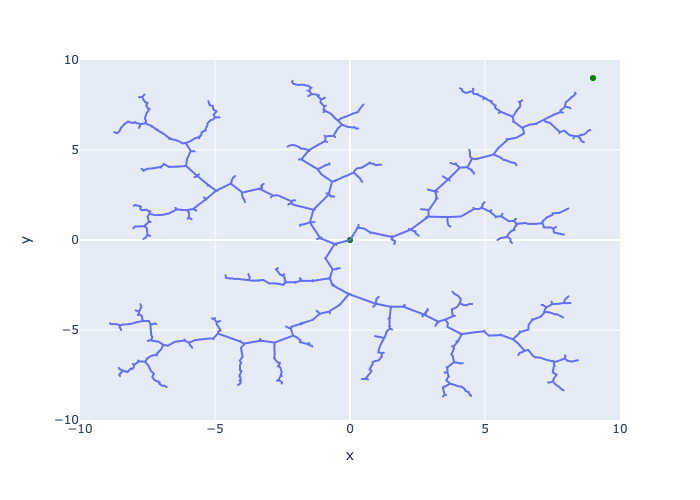

In [ ]:
#| caption: Rapidly Exploring Random Tree (RRT) from start to goal. The green points are the start and goal.
#| label: fig:rrt_example
xs, ys, group = [], [], []
for i, node in enumerate(rrt[1:]):
  # create line from parent to next node
  x, y = rrt[parents[i+1]]
  xs.append(x)
  ys.append(y)
  x, y = node
  xs.append(x)
  ys.append(y)
  group.append(i)
  group.append(i)
fig = px.line(x=xs, y=ys, line_group=group)

# add start and goal as green points
fig.add_scatter(x=[start[0], goal[0]], y=[start[1], goal[1]],
                  mode="markers", marker=dict(color="green"))
fig.update_layout(showlegend=False)
fig.update_xaxes(range=[-10, 10], autorange=False,scaleratio = 1)
fig.update_yaxes(range=[-10, 10], autorange=False,scaleratio = 1);
fig.show()